# Bi-gramas, TF-IDF, PCA

El objetivo de esta sección es tomar como input el pre-procesamiento de la información realizada en los pasos anteriores (interpretación de emojis, stopwords, lematización, etc) y explorar el comportamiento cuando se realiza el análisis por bigrama, TF-IDF y PCA


Aplicaremos:

*   Tf-Idf
*   PCA



In [1]:
!pip install transformers pandas scikit-learn accelerate emoji fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import torch
import pandas as pd
import numpy as np
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42)


In [3]:
# Verificar si hay una GPU disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Imprimir información sobre los dispositivos CUDA
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Usando dispositivo: cuda
True
1
Tesla T4


In [47]:
# ejecutar luego de subir archivo excel o tener vinculado Google Drive
import os
import pandas as pd
from google.colab import drive
# mensajes_preprocesados.csv
# columna: sin_stop_words_significado_emoticones

if os.path.isfile("/content/mensajes_trabajo_final1.xlsx"):
  data = pd.read_excel("/content/mensajes_trabajo_final.xlsx")
else:
  # Montar Google Drive
  drive.mount('/content/drive')

  # Cambia el path al archivo que hayas subido a tu Google Drive
  file_path = '/content/drive/MyDrive/UCU-NLP/mensajes_preprocesados.csv'

  # Cargar el archivo Excel
  data_total = pd.read_csv(file_path)

print("Datos cargados")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos cargados


In [48]:
# Seleccionar las columnas relevantes
data_recortado = data_total[['enviado','recibido', 'clase','recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words']]


# Mostrar las primeras filas del archivo
print(data_recortado.head())

                                             enviado              recibido  \
0  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
1  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
2  Hemos llegado al final de nuestro programa de ...               Gracias   
3  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
4  ¡Te damos la bienvenida! Recibirás un mensaje ...  Bueno muchas gracias   

            clase  \
0           optin   
1           optin   
2  agradecimiento   
3           optin   
4  agradecimiento   

  recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words  
0                               si quiero recibirlos                   
1                               si quiero recibirlos                   
2                                            gracias                   
3                               si quiero recibirlos                   
4                               bueno muchas

In [49]:
# agrupar clases

data = data_recortado.copy()
data.loc[data['clase'] == 'agradecimiento', 'clase'] = 'agradecimiento o saludo'
data.loc[data['clase'] == 'saludo', 'clase'] = 'agradecimiento o saludo'
data.loc[data['clase'] == 'medicación', 'clase'] = 'medicación o turno'
data.loc[data['clase'] == 'turno', 'clase'] = 'medicación o turno'
data.loc[data['clase'] == 'queja', 'clase'] = 'otros'
data.loc[data['clase'] == 'pregunta', 'clase'] = 'otros'
data.loc[data['clase'] == 'respuesta a consejo o pregunta', 'clase'] = 'respuesta'

In [50]:
# Convertir etiquetas de clase a representación numérica (suponiendo que son cadenas)
data['clase'] = data['clase'].astype('category')
data['clases_cat'] = data['clase'].cat.codes

In [51]:
# Convertir etiquetas de clase a representación numérica (suponiendo que son cadenas)
data['clase'] = data['clase'].astype('category')
data['clases_cat'] = data['clase'].cat.codes

# Filtrar las filas con etiquetas inválidas
data = data[data['clases_cat'] >= 0]

# Verificar que todas las etiquetas estén en el rango correcto
num_labels = len(data['clase'].unique())
print(f"Numero de etiquetas: {num_labels}")
print(f"Etiquetas unicas: {data['clases_cat'].unique()}")
assert data['clases_cat'].min() >= 0 and data['clases_cat'].max() < num_labels

Numero de etiquetas: 9
Etiquetas unicas: [6 0 8 5 7 2 1 3 4]


In [52]:
print("Columnas: ")
column_names = data.columns
print(column_names)

print(data.head())

Columnas: 
Index(['enviado', 'recibido', 'clase',
       'recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words',
       'clases_cat'],
      dtype='object')
                                             enviado              recibido  \
0  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
1  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
2  Hemos llegado al final de nuestro programa de ...               Gracias   
3  ¡Te damos la bienvenida! Recibirás un mensaje ...  SÍ quiero recibirlos   
4  ¡Te damos la bienvenida! Recibirás un mensaje ...  Bueno muchas gracias   

                     clase  \
0                    optin   
1                    optin   
2  agradecimiento o saludo   
3                    optin   
4  agradecimiento o saludo   

  recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words  \
0                               si quiero recibirlos                    
1                               

In [53]:
# Reemplazar los valores NaN y vacíos por ''
#recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words
data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words'].fillna('', inplace=True)
data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words'] = data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words'].apply(lambda x: x.strip() if isinstance(x, str) else x)
data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words'].replace('', '', inplace=True)

# Extraer la columna 'sin_stop_words_significado_emoticones'
text_data = data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words']

# De la depuración anterior, quedan 7008 mensajes

In [54]:
# Crear una instancia de CountVectorizer
vectorizer = CountVectorizer()

# Ajustar y transformar los datos de texto
X = vectorizer.fit_transform(text_data)

# Convertir la matriz de características a un DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [55]:
# Obtener el número total de palabras distintas
total_distinct_words = len(vectorizer.get_feature_names_out())
print("Total de palabras distintas en el corpus:", total_distinct_words)

# Mostrar la matriz de características
print("Matriz de característidas distintas: ")
print(X_df)
print("Matriz de primeras 10 características de los 10 primeros mensajes: ")
print(X_df.iloc[:10, :10])  # Aquí mostramos las primeras 10 filas (comentarios de usuarios) y 10 columnas para una visualización más legible.

Se han truncado las últimas 5000 líneas del flujo de salida.
2022    0        0     0       0        0      0  
2023    0        0     0       0        0      0  
2024    0        0     0       0        0      0  
2025    0        0     0       0        0      0  
2026    0        0     0       0        0      0  
2027    0        0     0       0        0      0  
2028    0        0     0       0        0      0  
2029    0        0     0       0        0      0  
2030    0        0     0       0        0      0  
2031    0        0     0       0        0      0  
2032    0        0     0       0        0      0  
2033    0        0     0       0        0      0  
2034    0        0     0       0        0      0  
2035    0        0     0       0        0      0  
2036    0        0     0       0        0      0  
2037    0        0     0       0        0      0  
2038    0        0     0       0        0      0  
2039    0        0     0       0        0      0  
2040    0        0   

Dada la cantidad de palabras que componen nuestro corpus, la matriz de características total no aporta para su visualización. Se realiza filtrado de las 10 primeras columnas de los 10 primeros mensajes, pero el resultado visual tampoco es útil.

Se toman los 100 primeros mensajes y se ordena para cada línea como es la frecuencia de las palabras de mayor a menor.


In [56]:
# Limitar el DataFrame a las primeras 100 líneas
X_df_100 = X_df.iloc[:100]

# Contar y ordenar las palabras en cada línea
sorted_word_counts_per_line = []

for index, row in X_df_100.iterrows():
    # Obtener las palabras y sus conteos
    word_counts = row[row > 0].sort_values(ascending=False)
    # Crear una lista de tuplas (palabra, conteo)
    sorted_words = [(word, count) for word, count in zip(word_counts.index, word_counts.values)]
    sorted_word_counts_per_line.append(sorted_words)

# Mostrar las palabras ordenadas por línea
for i, sorted_words in enumerate(sorted_word_counts_per_line):
    print(f"Documento {i + 1}: {sorted_words}")

Documento 1: [('quiero', 1), ('recibirlos', 1), ('si', 1)]
Documento 2: [('quiero', 1), ('recibirlos', 1), ('si', 1)]
Documento 3: [('gracias', 1)]
Documento 4: [('quiero', 1), ('recibirlos', 1), ('si', 1)]
Documento 5: [('bueno', 1), ('gracias', 1), ('muchas', 1)]
Documento 6: [('bien', 1), ('gracias', 1)]
Documento 7: [('buen', 1), ('dia', 1), ('gracias', 1), ('muchas', 1)]
Documento 8: [('analisis', 1), ('buen', 1), ('dia', 1), ('hacerme', 1), ('nuevamente', 1), ('tengo', 1)]
Documento 9: [('felicidad', 1), ('gracias', 1), ('muchas', 1)]
Documento 10: [('buenos', 1), ('dias', 1), ('fondo', 1), ('hace', 1), ('hago', 1), ('no', 1), ('ojo', 1)]
Documento 11: [('si', 1)]
Documento 12: [('turno', 2), ('mil', 1), ('re', 1), ('puedo', 1), ('pueden', 1), ('programarme', 1), ('panza', 1), ('no', 1), ('buenos', 1), ('descompuesta', 1), ('llegar', 1), ('hoy', 1), ('favor', 1), ('escribo', 1), ('disculpas', 1), ('dias', 1), ('lunes', 1)]
Documento 13: [('quiero', 1), ('recibirlos', 1), ('si', 1


**BI-GRAMAS**

In [57]:
# Crear una instancia de CountVectorizer con ngram_range para bi-gramas
vectorizer_bigrama = CountVectorizer(ngram_range=(2, 2))

# Ajustar y transformar los datos de texto
X_bigrama = vectorizer_bigrama.fit_transform(text_data)

# Convertir la matriz de características a un DataFrame
X_df_bigrama = pd.DataFrame(X_bigrama.toarray(), columns=vectorizer_bigrama.get_feature_names_out())



In [58]:
# Mostrar la matriz de características
print(X_df_bigrama)
print(X_df_bigrama.iloc[:10, :10])  # Mostramos las primeras 10 filas y 10 columnas para una visualización más legible.

      00 17  00 18  00 hora  00 horas  00 sabado  04 envios  05 2024  \
0         0      0        0         0          0          0        0   
1         0      0        0         0          0          0        0   
2         0      0        0         0          0          0        0   
3         0      0        0         0          0          0        0   
4         0      0        0         0          0          0        0   
5         0      0        0         0          0          0        0   
6         0      0        0         0          0          0        0   
7         0      0        0         0          0          0        0   
8         0      0        0         0          0          0        0   
9         0      0        0         0          0          0        0   
10        0      0        0         0          0          0        0   
11        0      0        0         0          0          0        0   
12        0      0        0         0          0          0     

In [59]:
# Configurar Pandas para mostrar todas las filas
pd.set_option('display.max_rows', None)

In [81]:
# Sumar las ocurrencias de cada bi-grama en todos los documentos
bigram_counts = X_df_bigrama.sum(axis=0)

# Filtrar los bi-gramas cuya cantidad es mayor a 1
bigram_counts_filtered = bigram_counts[bigram_counts > 0]

# Ordenar los bi-gramas por sus conteos en orden descendente
bigram_counts_sorted = bigram_counts_filtered.sort_values(ascending=False)

# Seleccionar los bi-gramas más frecuentes
top_60_bigrams = bigram_counts_sorted.head(60)

# Mostrar los 60 bi-gramas más frecuentes
print(top_60_bigrams)


si quiero                1701
quiero recibirlos        1658
muchas gracias            421
buen dia                  271
ok gracias                217
hola si                   123
buenas tardes             118
hola buen                 112
buenos dias               101
bueno gracias              96
hola buenas                75
si gracias                 74
no sabia                   67
no quiero                  66
gracias informacion        65
aprobacion aprobacion      62
no tengo                   61
gracias comunicarte        58
nombre nombre              55
si si                      54
hola gracias               53
gracias consejos           52
gracias consejo            50
dia gracias                47
bien gracias               45
no no                      44
si sabia                   43
dia si                     42
hola no                    39
gracias felicidad          35
ok muchas                  35
hola muchas                34
quiero recibirlo           33
podemos ay

In [77]:
# Buscar los bi-gramas que están relacionados a la palabra "glic" para identificar en que posición es que ranquean.

# Definimos procedimiento para encontar similares utilizando fuzzywuzzy
def contains_approximate_word(bigram, target_word, threshold=80):
    return fuzz.partial_ratio(bigram, target_word) > threshold

# Define la palabra objetivo y el umbral de coincidencia
target_word = "glicem"
threshold = 70  # Se prueba con valores 50, 60, 70 y 80.

# Filtrar los bi-gramas que contienen la palabra "glicemia" o variaciones similares
filtered_bigrams = top_60_bigrams[top_60_bigrams.index.to_series().apply(lambda x: contains_approximate_word(x, target_word, threshold))]

# Mostrar los bi-gramas filtrados
print(filtered_bigrams)
# Contar la cantidad de bi-gramas que cumplen con la condición
count_filtered_bigrams = len(filtered_bigrams)
print(f'Cantidad de bi-gramas que cumplen: {count_filtered_bigrams}')


normal glucemia         1
tomando glucemix        1
toman glucemia          1
ultimo realice          1
valorhemogb glic        1
si realice              1
controlar glucemia      1
analisis glucemea       1
170 glucemia            1
baja glucemia           1
bajar glucemia          1
medi glucemia           1
hacer analice           1
glucemix 850            1
glucemia sali           1
glucemia prueba         1
glucemia hemoglobina    1
glucemia cuida          1
glucemia 140            1
glucemea di             1
dtype: int64
Cantidad de bi-gramas que cumplen: 20


In [63]:
# Cantidad total de bi-gramas detectados
print("Cantidad total de bigramas detectados: ")
print(len(bigram_counts_sorted))

Cantidad total de bigramas detectados: 
7416



**TF-IDF**

In [82]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_data)

In [83]:
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
print(tfidf_df.head(20))  # Mostrar los primeros 20 documentos (textos) con sus TF-IDF

     00   04   05   06   08  0800   09   10  100  101  ...  yde  yendo  yes  \
0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.

Listamos las palabras mas relevantes para cada línea tomando los 20 primeros mensajes.

In [84]:
# Listar las palabras más relevantes de cada línea
for index, row in tfidf_df.iterrows():
    if index >= 20:  # Limitar a los primeros 20 mensajes
        break
    # Obtener los índices de las palabras con mayor TF-IDF
    top_indices = row.argsort()[::-1][:5]  # Obtener los 5 más altos
    top_words = [(feature_names[i], row[i]) for i in top_indices if row[i] > 0]  # Filtrar palabras con valor > 0
    print(f'Documento {index + 1}:', top_words)

Documento 1: [('recibirlos', 0.6209941066335374), ('quiero', 0.600551954929333), ('si', 0.503690052469742)]
Documento 2: [('recibirlos', 0.6209941066335374), ('quiero', 0.600551954929333), ('si', 0.503690052469742)]
Documento 3: [('gracias', 1.0)]
Documento 4: [('recibirlos', 0.6209941066335374), ('quiero', 0.600551954929333), ('si', 0.503690052469742)]
Documento 5: [('bueno', 0.6947065405241306), ('muchas', 0.6174591457283397), ('gracias', 0.36895396177493944)]
Documento 6: [('bien', 0.9032029317583075), ('gracias', 0.42921377431671276)]
Documento 7: [('buen', 0.577753751974719), ('dia', 0.5502385096257977), ('muchas', 0.5175085174916217), ('gracias', 0.3092298803924672)]
Documento 8: [('nuevamente', 0.5745695626745371), ('hacerme', 0.485299758129759), ('analisis', 0.4015722631396462), ('tengo', 0.31630505867260955), ('buen', 0.30123244474132005)]
Documento 9: [('felicidad', 0.7744953867042901), ('muchas', 0.543021940824328), ('gracias', 0.32447506492356587)]
Documento 10: [('ojo', 0.

In [87]:
# Defino en la variabla corpus la concatenación de todas las líneas de mensajes
corpus = data['recibido_corregido_significado_emoticones_sin_tildes_sin_stop_words'].tolist()  # Extraer los mensajes como lista

# Calcular TF-IDF para todo el corpus
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Convertir a DataFrame para un análisis más fácil
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calcular la media de TF-IDF para cada palabra en el corpus
mean_tfidf = tfidf_df.mean(axis=0)

# Obtener las palabras más relevantes (mayor TF-IDF medio)
top_indices = mean_tfidf.argsort()[::-1][:50]  # Top 50 palabras
top_words = [(vectorizer.get_feature_names_out()[i], mean_tfidf[i]) for i in top_indices]


In [88]:
# Convertir la lista de palabras y valores a un DataFrame
top_words_df = pd.DataFrame(top_words, columns=['Palabra', 'Valor TF-IDF'])

# Ordenar el DataFrame de mayor a menor según el valor TF-IDF
top_words_df = top_words_df.sort_values(by='Valor TF-IDF', ascending=False)

# Mostrar el DataFrame ordenado
print(top_words_df)

        Palabra  Valor TF-IDF
0            si      0.185597
1        quiero      0.148377
2    recibirlos      0.145729
3       gracias      0.141263
4            ok      0.078093
5    aprobacion      0.058434
6          hola      0.049224
7            no      0.040116
8        muchas      0.034540
9         bueno      0.028494
10          dia      0.018749
11         buen      0.017024
12         bien      0.012416
13        sabia      0.010565
14         dias      0.009518
15        tengo      0.009289
16       buenas      0.008708
17       nombre      0.008677
18       buenos      0.008367
19       afecto      0.008247
20    felicidad      0.008072
21  informacion      0.007227
22       tardes      0.007113
23     consejos      0.006844
24      consejo      0.005916
25         beso      0.005711
26        turno      0.005368
27           ya      0.005352
28         hace      0.004886
29          muy      0.004625
30         hago      0.004603
31         nada      0.004339
32       n

In [112]:
print(top_words_df.iloc[2])
#print(top_words_df.shape[0])

Palabra         recibirlos
Valor TF-IDF      0.145729
Name: 2, dtype: object



Continuamos con el análisis, aplicamos PCA para la reducción de dimensionalidad y de esta manera quedarnos con las 50 palabras mas representativas.

El resultado abierto por cada mensaje procesado (línea de comentario del dataframe), en nuestro caso indicamos las 50 primeras y por ese motivo solo vemos 50 componentes procesados.
Para cada línea muestra las palabras con su respectivo peso/carga

Se calcula la suma de los valores absolutos de las cargas de cada palabra en todos los componentes principales (documentos). Esto proporciona una medida de la importancia general de cada palabra en el conjunto de datos, considerando su presencia en todos los componentes principales.

In [135]:
# Obtener las palabras (columnas) y sus valores TF-IDF
words = tfidf_df.columns

# Estandarizar los Datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df.T)  # Transponer para estandarizar características (palabras) en lugar de documentos

# Aplicar PCA
pca = PCA(n_components=1)  # Reducir a una sola dimensión
X_pca = pca.fit_transform(X_scaled)

# Crear un DataFrame con los valores de PCA y las palabras correspondientes
pca_values = pd.DataFrame(X_pca, columns=['PCA_Value'])
pca_values['Word'] = words

# Ordenar por valor PCA de mayor a menor
result_df_sorted = pca_values.sort_values(by='PCA_Value', ascending=False)

# Mostrar los resultados
print(result_df_sorted)


        PCA_Value              Word
2273  1261.248944                si
2079  1223.392875        recibirlos
2031  1217.615931            quiero
1170    39.522984           gracias
1699    32.700603                no
1254    27.065629              hola
2078     9.254664         recibirlo
398      7.321301             bueno
2181     7.223048             sabia
1638     5.961533            muchas
2076     3.670438           recibir
1759     3.465404                ok
801      3.349742               dia
394      2.891193              buen
816      1.247936              dias
396      1.016934            buenas
1212     0.936618              hago
367      0.772462              bien
2391     0.433339             tengo
2367     0.308849            tardes
2607     0.024578                ya
399     -0.138443            buenos
363     -0.198141              beso
219     -0.244107        aprobacion
1564    -0.257787           mensaje
2465    -0.286565             turno
596     -0.324728          c

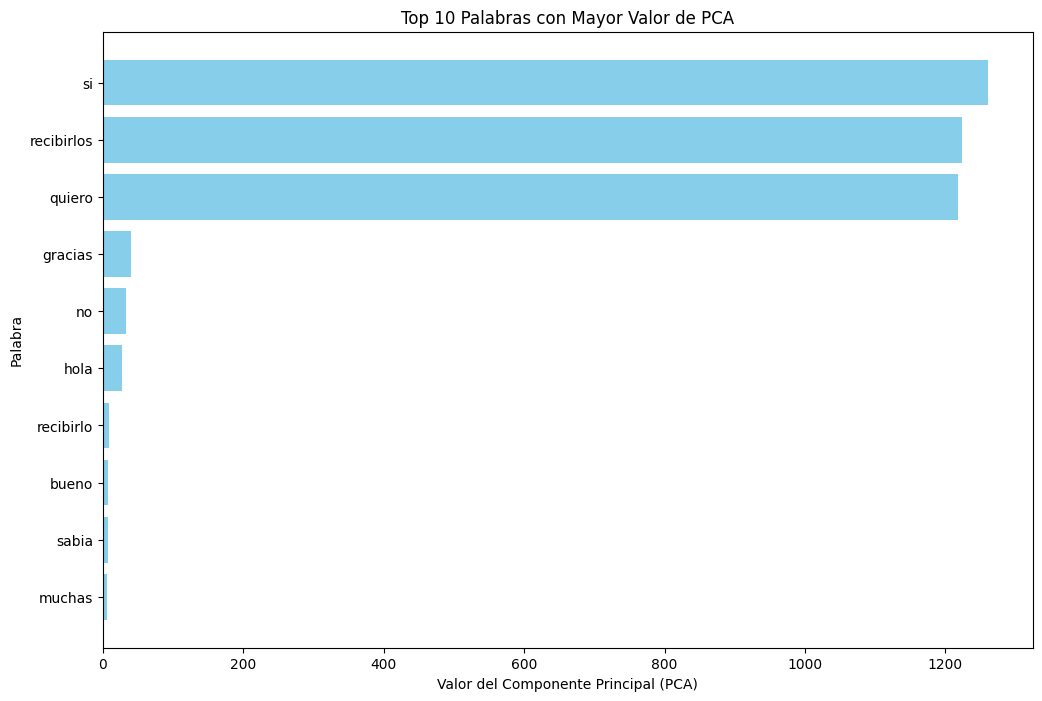

In [139]:
# Gráfica para las 10 palabras con mejor PCA
top_10_pca = pca_values.sort_values(by='PCA_Value', ascending=False).head(10)
# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.barh(top_10_pca['Word'], top_10_pca['PCA_Value'], color='skyblue')
plt.xlabel('Valor del Componente Principal (PCA)')
plt.ylabel('Palabra')
plt.title('Top 10 Palabras con Mayor Valor de PCA')
plt.gca().invert_yaxis()  # Invertir el eje Y para que la palabra con el valor más alto esté en la parte superior
plt.show()
